# When the Curious Abandon Honesty: Federated Learning is not Private

This notebook shows an example for the threat model and attack described in "When the Curious Abandon Honesty: Federated Learning is not Private". This example deviates from the other "honest-but-curious" server models and investigates an actively malicious model. As such, the attack applies to any model architecture, but its impact is more or less obvious (or not at all) depending on the already present architecture onto which the malicious "Imprint" block is grafted.

**Important:** This is the opposite framing from the original work, where this is conceptualized as a "malicious parameters" attack which is valid agaginst models with contain a layer structure of, for example, only fully connected layers or only convolutions without strides and fully connected layers. Both viewpoints are equally valid, but we like the "malicious-model" view point which allows the attack to be applied to any model, instead of having to preselect vulnerable architectures.


Paper URL: https://arxiv.org/abs/2112.02918

### Abstract:

In federated learning (FL), data does not leave personal devices when they are jointly training a machine learning model. Instead, these devices share gradients with a central party (e.g., a company). Because data never "leaves" personal devices, FL is presented as privacy-preserving. Yet, recently it was shown that this protection is but a thin facade, as even a passive attacker observing gradients can reconstruct data of individual users. In this paper, we argue that prior work still largely underestimates the vulnerability of FL. This is because prior efforts exclusively consider passive attackers that are honest-but-curious. Instead, we introduce an active and dishonest attacker acting as the central party, who is able to modify the shared model's weights before users compute model gradients. We call the modified weights "trap weights". Our active attacker is able to recover user data perfectly and at near zero costs: the attack requires no complex optimization objectives. Instead, it exploits inherent data leakage from model gradients and amplifies this effect by maliciously altering the weights of the shared model. These specificities enable our attack to scale to models trained with large mini-batches of data. Where attackers from prior work require hours to recover a single data point, our method needs milliseconds to capture the full mini-batch of data from both fully-connected and convolutional deep neural networks. Finally, we consider mitigations. We observe that current implementations of differential privacy (DP) in FL are flawed, as they explicitly trust the central party with the crucial task of adding DP noise, and thus provide no protection against a malicious central party. We also consider other defenses and explain why they are similarly inadequate. A significant redesign of FL is required for it to provide any meaningful form of data privacy to users.

### Startup

In [5]:
try:
    import breaching
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    import os; os.chdir("..")
    import breaching
    
import torch
%load_ext autoreload
%autoreload 2

import math

# Redirects logs directly into the jupyter notebook
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Initialize cfg object and system setup:

This will load the full configuration object. This includes the configuration for the use case and threat model as `cfg.case` and the hyperparameters and implementation of the attack as `cfg.attack`. All parameters can be modified below, or overriden with `overrides=` as if they were cmd-line arguments.

In [6]:
cfg = breaching.get_config(overrides=["attack=imprint", "case/server=malicious-model-cah"])
          
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case single_imagenet with server type malicious_model.


{'device': device(type='cpu'), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations for the attack, or the case:

In [7]:
cfg.case.user.num_data_points = 64 # How many data points does this user own
cfg.case.server.model_modification.type = 'CuriousAbandonHonesty' # What type of Imprint block will be grafted to the model
cfg.case.server.model_modification.num_bins = 128 # How many bins are in the block

cfg.case.server.model_modification.position = None # '4.0.conv'
cfg.case.server.model_modification.connection = 'addition'

# Unnormalized data:
# cfg.case.data.normalize = False
# cfg.case.server.model_modification.mu = 0
# cfg.case.server.model_modification.sigma = 0.5
# cfg.case.server.model_modification.scale_factor = 1 - 0.990
# cfg.attack.breach_reduction = None # Will be done manually

# Normalized data:
cfg.case.data.normalize = True
cfg.case.server.model_modification.sigma = 0.5 * 0.2260
cfg.case.server.model_modification.mu = -0.4490 * math.sqrt(224**2*3) * 0.5
cfg.case.server.model_modification.scale_factor = -0.9990
cfg.attack.breach_reduction = None # Will be done manually

### Instantiate all parties

The following lines generate "server, "user" and "attacker" objects and print an overview of their configurations.

In [8]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

First layer determined to be model.conv1
Block inserted at feature shape torch.Size([3, 224, 224]).
Model architecture ResNet18 loaded with 30,647,885 parameters and 9,620 buffers.
Overall this is a data ratio of       3:1 for target shape [64, 3, 224, 224] given that num_queries=1.
User (of type UserSingleStep) with settings:
    Number of data points: 64

    Threat model:
    User provides labels: False
    User provides buffers: False
    User provides number of data points: True

    Data:
    Dataset: ImageNetAnimals
    user: 0
    
        
Server (of type MaliciousModelServer) with settings:
    Threat model: Malicious (Analyst)
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: ResNet18
        model state: default
        public buffers: True

    Secrets: {'ImprintBlock': {'weight_idx': 0, 'bias_idx': 1, 'shape': torch.Size([3, 224, 224]), 'structure': 'sparse'}}
    
Attacker (of type ImprintAttacker).


### Simulate an attacked FL protocol

This exchange is a simulation of a single query in a federated learning protocol. The server sends out a `server_payload` and the user computes an update based on their private local data. This user update is `shared_data` and contains, for example, the parameter gradient of the model in the simplest case. `true_user_data` is also returned by `.compute_local_updates`, but of course not forwarded to the server or attacker and only used for (our) analysis.

In [9]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)  

Computing user update in model mode: eval.


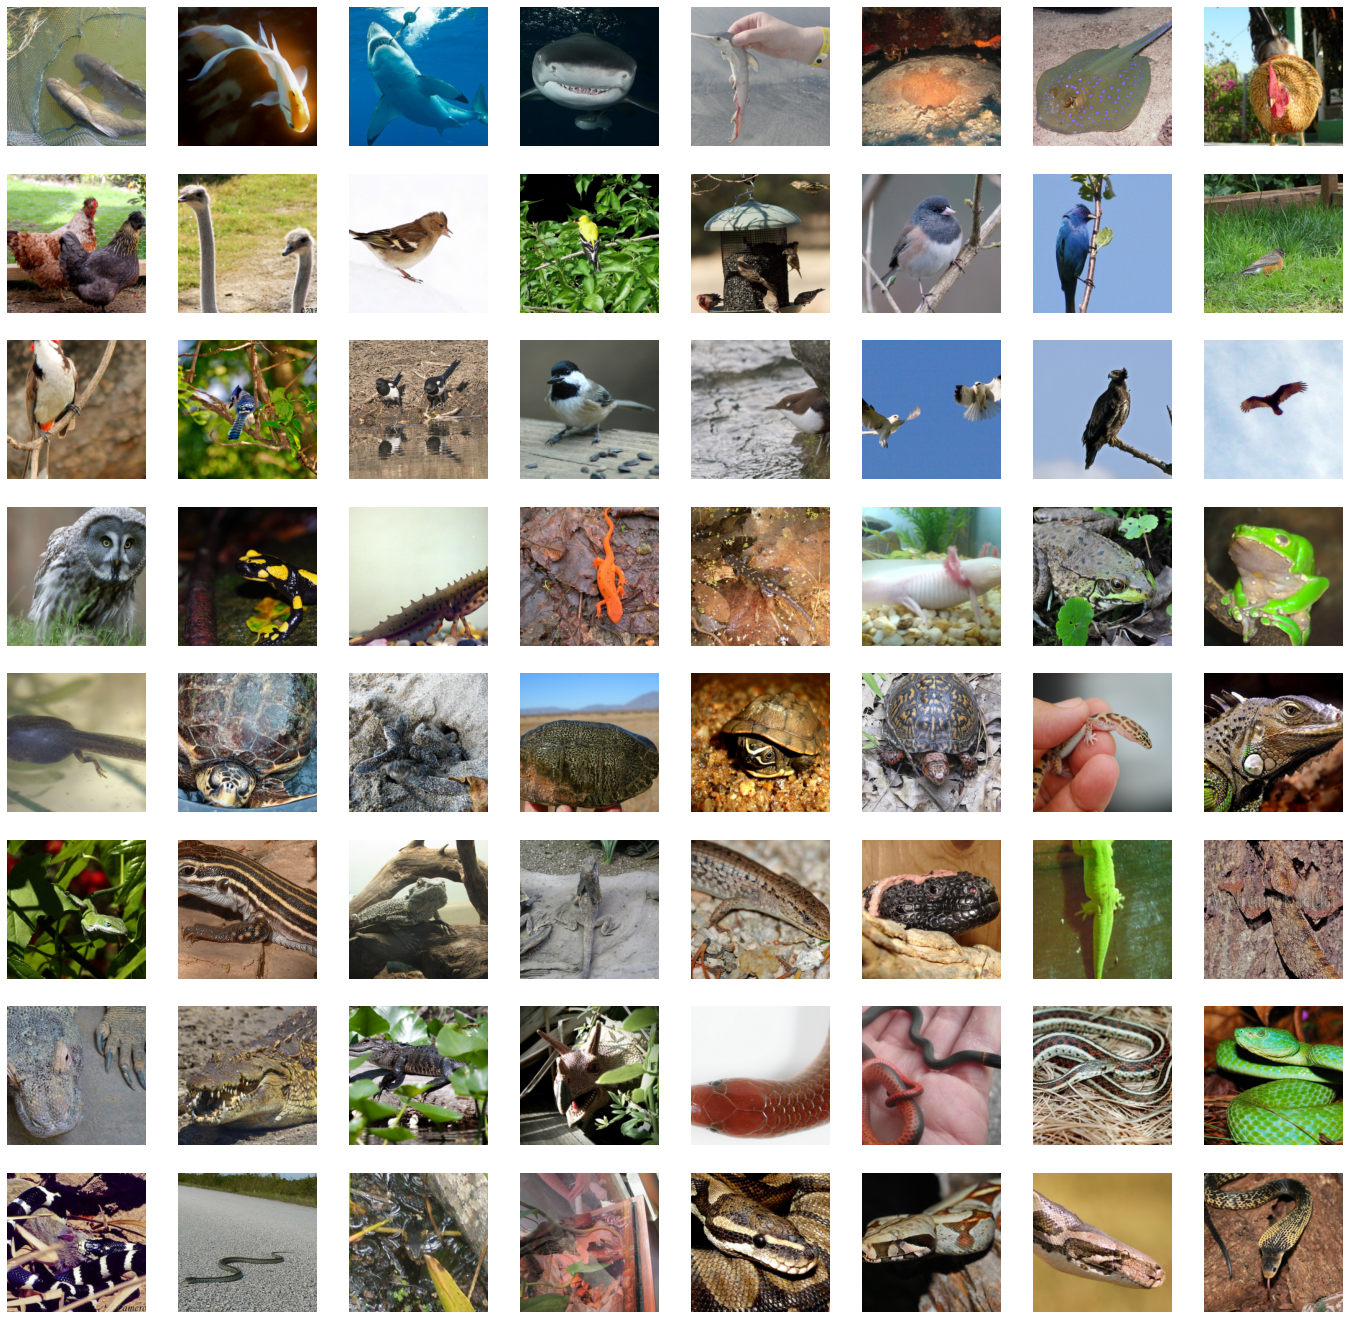

In [10]:
user.plot(true_user_data)

### Reconstruct user data:

Now we launch the attack, reconstructing user data based on only the `server_payload` and the `shared_data`. 

For this attack, we also share secret information from the malicious server with the attack (`server.secrets`), which here is the location and structure of the imprint block.

In [11]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], server.secrets, 
                                                      dryrun=cfg.dryrun)

Initially produced 118 hits.


Next we'll evaluate metrics, comparing the `reconstructed_user_data` to the `true_user_data`.

### Remove mixed images by direct GT comparison

In [16]:
reconstructed = torch.zeros_like(true_user_data["data"])
for sample in reconstructed_user_data["data"]:
        l2_dists = (sample[None] - true_user_data["data"]).pow(2).mean(dim=[1, 2, 3])
        min_dist, min_idx = l2_dists.min(dim=0)
        if min_dist < 1e-1:
            reconstructed[min_idx] = sample
reconstructed_user_data = dict(data=reconstructed, labels=None)

In [14]:
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

METRICS: | MSE: 0.0330 | PSNR: 52.27 | FMSE: 2.3898e+01 | LPIPS: 0.58|
 R-PSNR: 52.53 | IIP-pixel: 40.62% | SSIM: 0.3656 | max R-PSNR: 170.93 | max SSIM: 1.0000 | Label Acc: 0.00%


And finally, we also plot the reconstructed data:

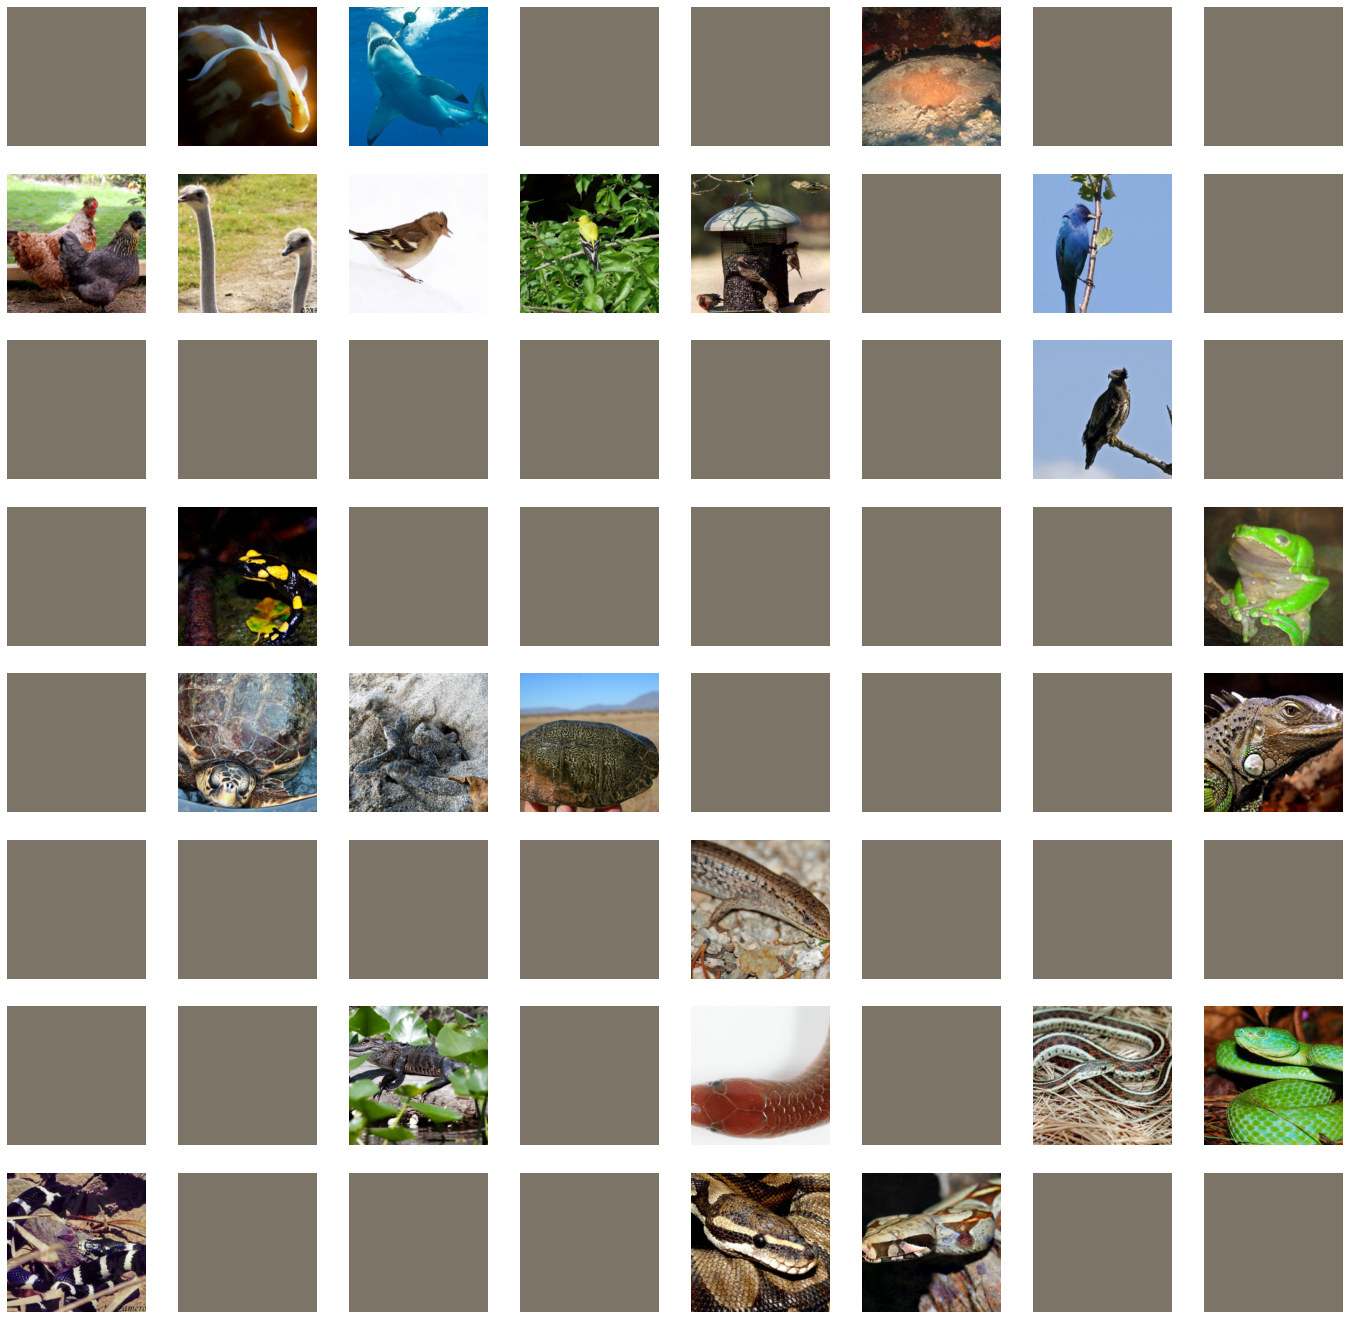

In [15]:
user.plot(reconstructed_user_data)

### Notes:
* 